<a href="https://colab.research.google.com/github/RajaSuhashKesari/MyDataEngineeringPractices/blob/main/Pyspark%20Programs/Module_5_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('Logs').getOrCreate()

In [ ]:
sc=spark.sparkContext

# **1. Load file as a text file in spark**

In [ ]:
logs_rdd = sc.textFile('/content/access.log')
logs_rdd.take(10)

['',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] POST /administrator/index.php HTTP/1.1 200 4494 htt

In [ ]:
for i in logs_rdd.map(lambda x: x.split(' ')).collect():
  if len(i) == 53 :
    print(i)

['95.181.179.162', '-', '-', '[22/Jan/2016:11:33:36', '+0100]', 'GET', '/wp-login.php', 'HTTP/1.1', '404', '218', '-', 'Mozilla/4.0', '(compatible', '', 'MSIE', '8.0', '', 'Windows', 'NT', '6.1', '', 'Trident/4.0', '', 'MRSPUTNIK', '2,', '4,', '0,', '270', '', 'MRA', '5.8', '(build', '4110)', '', 'SLCC2', '', '.NET', 'CLR', '2.0.50727', '', '.NET', 'CLR', '3.5.30729', '', '.NET', 'CLR', '3.0.30729', '', 'Media', 'Center', 'PC', '6.0)', '-']


# **2. Find out how many 404 HTTP codes are in access logs.**


In [ ]:
HTTP_codes_404= logs_rdd.filter(lambda x: '404' in x)
print("The number of 404 http codes present :",HTTP_codes_404.count())

The number of 404 http codes present : 119664


# **3. Find out which URLs are broken**


In [ ]:
broken_urls_rdd = logs_rdd.filter(lambda x: '404' in x).map(lambda x: x.split(' ')[6])
for i in broken_urls_rdd.take(20):
  print(i)

/templates/_system/css/general.css
/templates/_system/css/general.css
/favicon.ico
/icons/text.gif
/templates/_system/css/general.css
/apache-log/error.log.44.gz
/apache-log/access.log.69.gz
/apache-log/error.log.55.gz
/templates/_system/css/general.css
/favicon.ico
/templates/_system/css/general.css
/templates/_system/css/general.css
/templates/_system/css/general.css
/templates/_system/css/general.css
/templates/_system/css/general.css
/favicon.ico
/favicon.ico
/templates/_system/css/general.css
/templates/_system/css/general.css
/templates/_system/css/general.css


# **4. Verify there are no null columns in the original dataset**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract

# Start Spark session
spark = SparkSession.builder.appName("ApacheLogParser").getOrCreate()

# Read the log file as a text file
log_file_path = "/content/access.log"
logs_df = spark.read.text(log_file_path)

# Define regex pattern
log_pattern = r'^(\S+) - - \[(.*?)\] (\S+) (\S+) \S+ (\d{3}) (\d+) (\S+) (.+)$'

# Extract fields using regex
logs_df = logs_df.selectExpr("value as line") \
    .withColumn("ip", regexp_extract("line", log_pattern, 1)) \
    .withColumn("timestamp", regexp_extract("line", log_pattern, 2)) \
    .withColumn("method", regexp_extract("line", log_pattern, 3)) \
    .withColumn("endpoint", regexp_extract("line", log_pattern, 4)) \
    .withColumn("status_code", regexp_extract("line", log_pattern, 5)) \
    .withColumn("size", regexp_extract("line", log_pattern, 6)) \
    .withColumn("referrer", regexp_extract("line", log_pattern, 7)) \
    .withColumn("user_agent", regexp_extract("line", log_pattern, 8)) \
    .drop("line")

In [ ]:
from pyspark.sql.functions import col

# Count rows with at least one null
null_rows_count = logs_df.filter(
    sum(col(c).isNull().cast("int") for c in logs_df.columns) > 0
).count()

print(f"Number of rows with at least one null value: {null_rows_count}")


Number of rows with at least one null value: 0


# **5. Replace null values with constants such as 0**

In [ ]:
# Fill null values with 0
logs_df_filled = logs_df.fillna("0")  # This fills nulls in all columns with "0" (as string)

# If you want to fill numeric columns with integer 0 and leave strings alone:
logs_df_filled = logs_df.fillna({
    "status_code": "0",
    "size": "0"
})

# Show the DataFrame
logs_df_filled.show(truncate=False)

+---------------+--------------------------+------+------------------------+-----------+----+----------------------------------------+-------------------------------------------------------------------+
|ip             |timestamp                 |method|endpoint                |status_code|size|referrer                                |user_agent                                                         |
+---------------+--------------------------+------+------------------------+-----------+----+----------------------------------------+-------------------------------------------------------------------+
|               |                          |      |                        |           |    |                                        |                                                                   |
|109.169.248.247|12/Dec/2015:18:25:11 +0100|GET   |/administrator/         |200        |4263|-                                       |Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 F

# **6. Parse timestamp to readable date**

In [ ]:
from pyspark.sql.functions import to_timestamp

# Parse timestamp to proper format
logs_df = logs_df.withColumn(
    "parsed_timestamp",
    to_timestamp("timestamp", "dd/MMM/yyyy:HH:mm:ss Z")
)
logs_df = logs_df.drop("timestamp").withColumnRenamed("parsed_timestamp", "timestamp")
logs_df.show(truncate=False)

+---------------+------+------------------------+-----------+----+----------------------------------------+-------------------------------------------------------------------+-------------------+
|ip             |method|endpoint                |status_code|size|referrer                                |user_agent                                                         |timestamp          |
+---------------+------+------------------------+-----------+----+----------------------------------------+-------------------------------------------------------------------+-------------------+
|               |      |                        |           |    |                                        |                                                                   |NULL               |
|109.169.248.247|GET   |/administrator/         |200        |4263|-                                       |Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -|2015-12-12 17:25:11|
|109.169.248.247|POS

# **7. Describe which HTTP status values appear in data and how many**


In [ ]:
status_df = logs_df.groupBy("status_code").count().orderBy("count", ascending=False)
status_df.show()

+-----------+-------+
|status_code|  count|
+-----------+-------+
|        200|1009470|
|        206| 404895|
|        404| 119350|
|           |   6463|
|        500|   1079|
|        301|    589|
|        303|    234|
|        501|    103|
|        403|     48|
|        405|     36|
|        412|     19|
|        400|      5|
+-----------+-------+



# **8. Display as chart the above stat in chart in Zeppelin notebook**

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

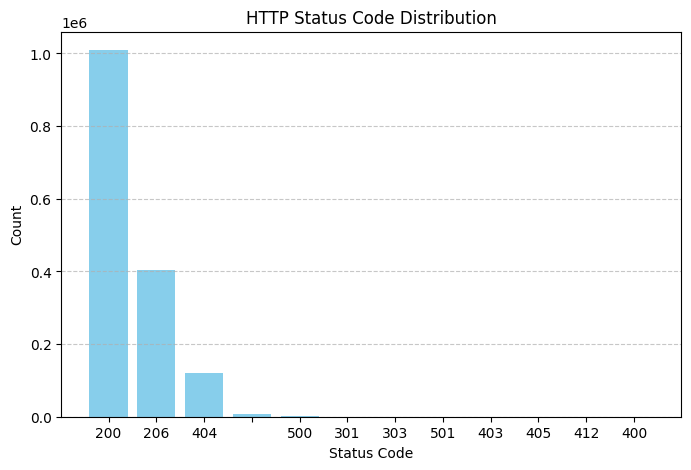

In [ ]:
status_df = logs_df.groupBy("status_code").count().orderBy("count", ascending=False)

# Convert to Pandas for plotting
pdf = status_df.toPandas()

# Plot using Matplotlib
plt.figure(figsize=(8, 5))
plt.bar(pdf['status_code'].astype(str), pdf['count'], color='skyblue')
plt.title("HTTP Status Code Distribution")
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **9. How many unique hosts are there in the entire log and their average request**

In [ ]:
from pyspark.sql.functions import countDistinct, count

# Total number of requests
total_requests = logs_df.count()

# Number of unique hosts (IPs)
unique_hosts = logs_df.select("ip").distinct().count()

# Average requests per host
average_requests_per_host = total_requests / unique_hosts if unique_hosts != 0 else 0

print(f"Total Requests: {total_requests}")
print(f"Unique Hosts: {unique_hosts}")
print(f"Average Requests per Host: {average_requests_per_host:.2f}")

Total Requests: 1542291
Unique Hosts: 39508
Average Requests per Host: 39.04
